<a href="https://colab.research.google.com/github/Kamruzzaman2200/Ai/blob/main/k_fold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries

In [1]:
!pip install imblearn boruta


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.9 MB/s eta 0:00:00


#Install libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data & preprocessing
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_validate

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from boruta import BorutaPy

# Estimators for RFE/Boruta
from sklearn.ensemble import RandomForestClassifier

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import make_scorer, accuracy_score


#Load data

In [3]:
try:
    df = pd.read_csv('/content/drive/MyDrive/DataSets/survey lung cancer.csv')
    print("✅ Loaded: survey lung cancer.csv")
except FileNotFoundError:
    raise SystemExit("❗️'/content/drive/MyDrive/DataSets/survey lung cancer.csv' not found. Upload it to your runtime and rerun.")

df.head()


✅ Loaded: survey lung cancer.csv


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


#Clean & encode

In [4]:
# Normalize column names
df.columns = df.columns.str.strip().str.lower()

# Encode binary strings → integers
for col in ['gender', 'lung_cancer']:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# (Optional) ensure all remaining yes/no indicators are numeric if present
# Example: convert 'yes'/'no' to 1/0 for all non-target columns
for col in df.columns:
    if df[col].dtype == 'O':
        vals = df[col].str.lower().str.strip()
        if set(vals.unique()) <= {'yes','no','1','0','y','n'}:
            df[col] = vals.map({'yes':1,'no':0,'y':1,'n':0,'1':1,'0':0}).astype(int)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   gender                 309 non-null    int64
 1   age                    309 non-null    int64
 2   smoking                309 non-null    int64
 3   yellow_fingers         309 non-null    int64
 4   anxiety                309 non-null    int64
 5   peer_pressure          309 non-null    int64
 6   chronic disease        309 non-null    int64
 7   fatigue                309 non-null    int64
 8   allergy                309 non-null    int64
 9   wheezing               309 non-null    int64
 10  alcohol consuming      309 non-null    int64
 11  coughing               309 non-null    int64
 12  shortness of breath    309 non-null    int64
 13  swallowing difficulty  309 non-null    int64
 14  chest pain             309 non-null    int64
 15  lung_cancer            309 non-null    i

#Quick EDA: class balance

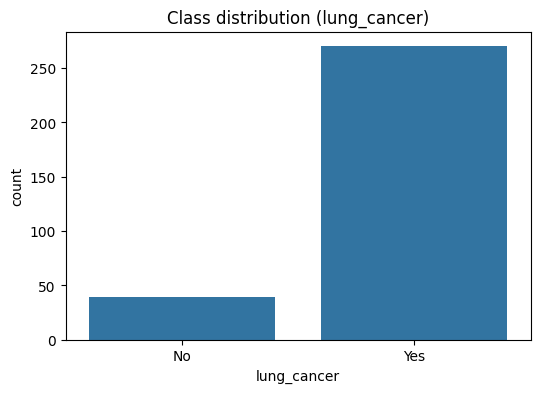

,proportion
lung_cancer,
1,0.873786
0,0.126214


In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='lung_cancer', data=df)
plt.title('Class distribution (lung_cancer)')
plt.xticks([0,1], ['No','Yes'])
plt.show()

df['lung_cancer'].value_counts(normalize=True).rename('proportion')


#Quick EDA: correlations

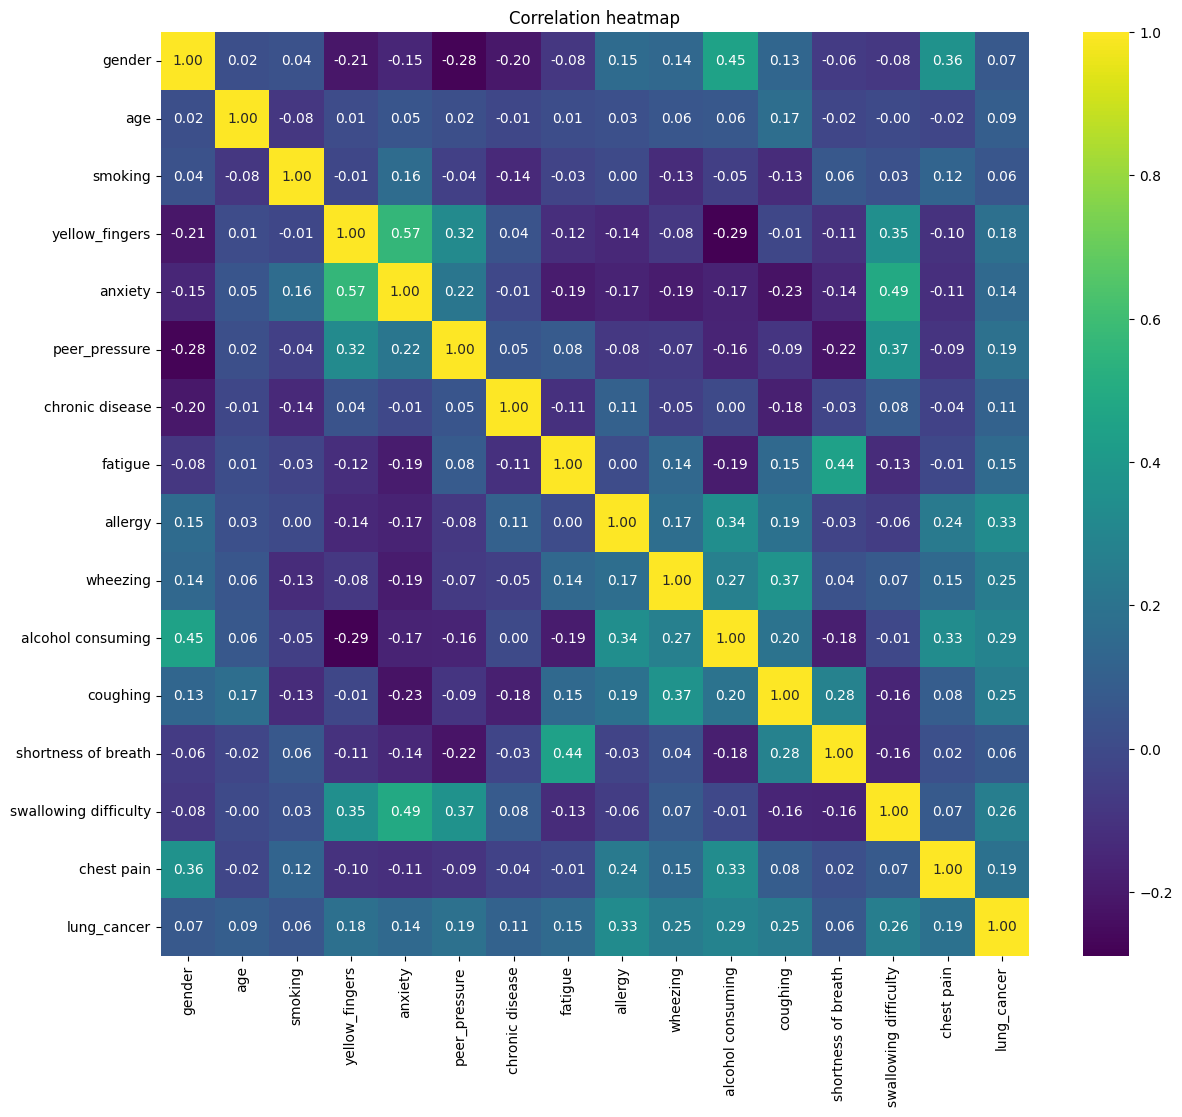

In [8]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(numeric_only=True), cmap='viridis', annot=True, fmt=".2f")
plt.title('Correlation heatmap')
plt.show()

#EDA t-SNE for visualization only

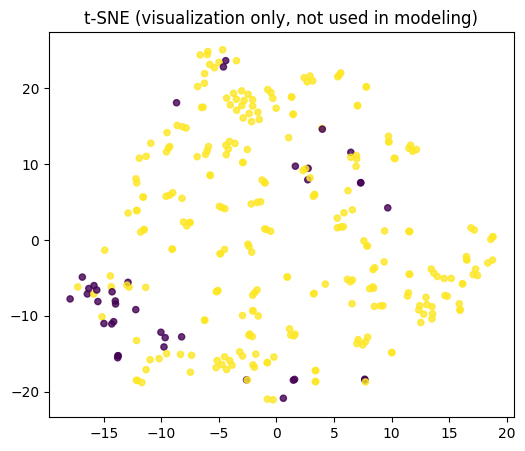

In [9]:
from sklearn.manifold import TSNE
X_vis = df.drop(columns=['lung_cancer'])
y_vis = df['lung_cancer']

# Simple scaling for visualization
X_vis_scaled = StandardScaler().fit_transform(X_vis)

tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
X2 = tsne.fit_transform(X_vis_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=y_vis, s=20, alpha=0.8)
plt.title('t-SNE (visualization only, not used in modeling)')
plt.show()


#Define X / y

In [10]:
X = df.drop(columns=['lung_cancer'])
y = df['lung_cancer'].astype(int)

print("X shape:", X.shape, "| y positive rate:", y.mean().round(3))


X shape: (309, 15) | y positive rate: 0.874


#Cross-validation plan

In [11]:
# K-Fold with repeats: e.g., 5 folds × 3 repeats = 15 evaluatons per combo
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

scoring = {'accuracy': make_scorer(accuracy_score)}


#Scalers & classifiers

In [12]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=None, random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(kernel='rbf', probability=False, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
}


#Feature engineering blocks (as callables for pipelines)

In [13]:
# We’ll create small factory functions that return the right step objects.

def pca_block():
    # keep 95% variance (robust to different feature counts)
    return ('pca', PCA(n_components=0.95, random_state=42))

def lda_block():
    # LDA used as supervised dimensionality reduction
    # n_components will default to n_classes-1
    return ('lda', LDA(solver='svd'))

def rfe_block():
    # RFE wrapped around a strong estimator
    base = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    return ('rfe', RFE(estimator=base, n_features_to_select=8, step=1))

def boruta_block():
    # BorutaPy expects numpy arrays; it works fine inside Pipeline
    base = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight='balanced')
    return ('boruta', BorutaPy(estimator=base, n_estimators='auto', verbose=0, random_state=42, max_iter=50))


#Define all method recipes

In [14]:
# Each method is a list of (name, step) pairs to be inserted after SMOTE.
# "All Features" means no dimensionality reduction or selection.

feature_methods = {
    "All Features": [],
    "PCA": [pca_block()],
    "LDA": [lda_block()],
    "RFE": [rfe_block()],
    "Boruta": [boruta_block()]
}


#Run full experiment with repeated Stratified K-Fold

In [16]:
results = []  # will store per-combo per-fold scores

for scaler_name, scaler in scalers.items():
    for method_name, method_steps in feature_methods.items():
        for clf_name, clf in classifiers.items():

            # Build pipeline: Scale → SMOTE → (feature method?) → Classifier
            steps = []
            steps.append(('scaler', scaler))
            steps.append(('smote', SMOTE(random_state=42)))
            for name, obj in method_steps:
                steps.append((name, obj))
            steps.append(('clf', clf))

            pipe = Pipeline(steps)

            cv_out = cross_validate(
                pipe, X, y,
                cv=cv,
                scoring=scoring,
                return_train_score=False,
                n_jobs=-1
            )

            # collect all individual fold scores
            fold_scores = cv_out['test_accuracy']  # array of shape (n_splits * n_repeats,)

            results.append({
                'Scaler': scaler_name,
                'Method': method_name,
                'Classifier': clf_name,
                'Fold_Scores': fold_scores,
                'Mean_Accuracy': float(np.mean(fold_scores)),
                'Std_Accuracy': float(np.std(fold_scores, ddof=1))
            })

# Convert to DataFrame (expand mean/std; keep fold vectors if you need them later)
results_df = pd.DataFrame(results).sort_values('Mean_Accuracy', ascending=False).reset_index(drop=True)

print("✅ Evaluation complete for all combinations.")
results_df[['Scaler','Method','Classifier','Mean_Accuracy','Std_Accuracy']].head(10)


✅ Evaluation complete for all combinations.


,Scaler,Method,Classifier,Mean_Accuracy,Std_Accuracy
0,StandardScaler,All Features,Random Forest,0.910559,0.041350
1,StandardScaler,PCA,Random Forest,0.910524,0.033829
2,MinMaxScaler,PCA,Random Forest,0.910488,0.040608
3,MinMaxScaler,All Features,Random Forest,0.909466,0.043058
4,RobustScaler,All Features,Random Forest,0.908408,0.043869
5,RobustScaler,Boruta,Random Forest,0.907280,0.039368
6,RobustScaler,PCA,Random Forest,0.904019,0.042626
7,StandardScaler,Boruta,Random Forest,0.904001,0.037486
8,MinMaxScaler,Boruta,Random Forest,0.901851,0.034899
9,MinMaxScaler,LDA,Random Forest,0.898502,0.053389


#Pretty table: mean ± std (sorted)

In [17]:
# Build a readable "mean ± std" column
disp = results_df.copy()
disp['Accuracy (mean ± std)'] = (disp['Mean_Accuracy']*100).round(2).astype(str) + \
                                '% ± ' + (disp['Std_Accuracy']*100).round(2).astype(str) + '%'

cols = ['Scaler', 'Method', 'Classifier', 'Accuracy (mean ± std)']
disp_table = disp[cols].sort_values(by='Accuracy (mean ± std)', ascending=False)
print("——— 🏆 Final Accuracy (mean ± std) across repeats × folds ———")
print(disp_table.to_string(index=False))


——— 🏆 Final Accuracy (mean ± std) across repeats × folds ———
        Scaler       Method          Classifier Accuracy (mean ± std)
StandardScaler All Features       Random Forest        91.06% ± 4.14%
  MinMaxScaler          PCA       Random Forest        91.05% ± 4.06%
StandardScaler          PCA       Random Forest        91.05% ± 3.38%
  MinMaxScaler All Features       Random Forest        90.95% ± 4.31%
  RobustScaler All Features       Random Forest        90.84% ± 4.39%
  RobustScaler       Boruta       Random Forest        90.73% ± 3.94%
  RobustScaler          PCA       Random Forest         90.4% ± 4.26%
StandardScaler       Boruta       Random Forest         90.4% ± 3.75%
  MinMaxScaler       Boruta       Random Forest        90.19% ± 3.49%
  MinMaxScaler          LDA       Random Forest        89.85% ± 5.34%
StandardScaler All Features Logistic Regression         89.65% ± 5.5%
  MinMaxScaler          LDA                 KNN        89.53% ± 4.59%
StandardScaler          LDA  

#Plot the top N combinations

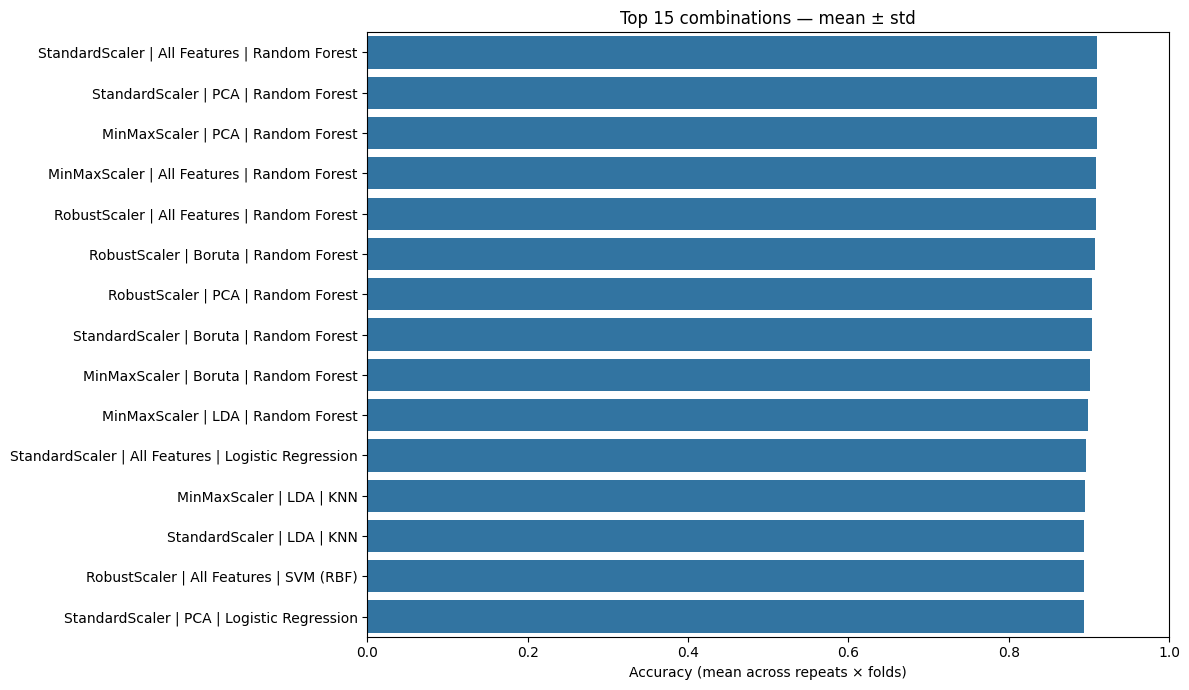

In [19]:
# Uses seaborn for a quick visual; feel free to disable if running headless.
top_n = 15
plot_df = results_df.head(top_n).copy()
plot_df['label'] = plot_df['Scaler'] + ' | ' + plot_df['Method'] + ' | ' + plot_df['Classifier']

plt.figure(figsize=(12, 7))
sns.barplot(
    data=plot_df,
    y='label', x='Mean_Accuracy',
    errorbar='sd'  # Use errorbar='sd' to automatically plot standard deviation
)
plt.xlim(0, 1)
plt.xlabel('Accuracy (mean across repeats × folds)')
plt.ylabel('')
plt.title(f'Top {top_n} combinations — mean ± std')
plt.tight_layout()
plt.show()

#Final Results Summary and Conclusion

In [22]:
# Pivot the results for a clean comparison table
# Using 'Method' for rows and 'Classifier' for columns, and 'Mean_Accuracy' for values
results_pivot = results_df.pivot_table(index='Method', columns='Classifier', values='Mean_Accuracy')

print("="*60)
print("          Summary of Model Accuracies (Mean Accuracy)")
print("="*60)
display(results_pivot.style.format("{:.4f}").background_gradient(cmap='Greens'))

          Summary of Model Accuracies (Mean Accuracy)


Classifier,KNN,Logistic Regression,Random Forest,SVM (RBF)
Method,,,,
All Features,0.8496,0.8882,0.9095,0.8910
Boruta,0.8507,0.8799,0.9044,0.8892
LDA,0.8900,0.8903,0.8867,0.8806
PCA,0.8493,0.8842,0.9083,0.8845
RFE,0.8465,0.8770,0.8871,0.8788


In [27]:
# Find the maximum accuracy
max_accuracy = results_df['Mean_Accuracy'].max()

# Filter the DataFrame to get all rows with the maximum accuracy
best_performing_models = results_df[results_df['Mean_Accuracy'] == max_accuracy].copy()

print("--- 🏆 Best Performing Models (Maximum Accuracy) ---")
print(f"Maximum Accuracy: {max_accuracy:.4f}")

# Display all combinations that achieved the maximum accuracy and their individual fold scores
if not best_performing_models.empty:
    for index, row in best_performing_models.iterrows():
        print(f"\nModel Combination: {row['Scaler']} | {row['Method']} | {row['Classifier']}")
        print(f"  Mean Accuracy: {row['Mean_Accuracy']:.4f}")
        print(f"  Standard Deviation of Accuracy: {row['Std_Accuracy']:.4f}")
        print("  Individual Fold Scores:")
        for i, score in enumerate(row['Fold_Scores']):
            print(f"    Fold {i+1}: {score:.4f}")
else:
    print("No models found with the maximum accuracy.")

--- 🏆 Best Performing Models (Maximum Accuracy) ---
Maximum Accuracy: 0.9106

Model Combination: StandardScaler | All Features | Random Forest
  Mean Accuracy: 0.9106
  Standard Deviation of Accuracy: 0.0414
  Individual Fold Scores:
    Fold 1: 0.9516
    Fold 2: 0.8871
    Fold 3: 0.8548
    Fold 4: 0.8710
    Fold 5: 0.9672
    Fold 6: 0.9194
    Fold 7: 0.9032
    Fold 8: 0.8387
    Fold 9: 0.9355
    Fold 10: 0.9836
    Fold 11: 0.9194
    Fold 12: 0.9032
    Fold 13: 0.9355
    Fold 14: 0.9194
    Fold 15: 0.8689
